## Image Interpolation

In [1]:
import cv2
import os
import numpy as np

# Paths
input_folder = "stage2"
output_folder = "stage2-interpolated"
os.makedirs(output_folder, exist_ok=True)

def interpolate_frames(frame1, frame2, num_interpolations=1):
    """
    Interpolates between two frames using linear interpolation.
    
    Args:
        frame1 (numpy.ndarray): First frame.
        frame2 (numpy.ndarray): Second frame.
        num_interpolations (int): Number of interpolated frames to generate.
    
    Returns:
        list: List of interpolated frames.
    """
    interpolated_frames = []
    for i in range(1, num_interpolations + 1):
        alpha = i / (num_interpolations + 1)  # Interpolation ratio
        interpolated_frame = cv2.addWeighted(frame1, 1 - alpha, frame2, alpha, 0)
        interpolated_frames.append(interpolated_frame)
    return interpolated_frames

def process_video(video_path, output_path, num_interpolations=1):
    """
    Processes a video to add interpolated frames and saves the result.
    
    Args:
        video_path (str): Path to the input video.
        output_path (str): Path to save the interpolated video.
        num_interpolations (int): Number of interpolated frames between each pair of original frames.
    """
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print(f"Failed to open video: {video_path}")
        return
    
    # Get video properties
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # Codec for .mp4 files
    
    # New FPS after interpolation
    new_fps = fps * (num_interpolations + 1)
    out = cv2.VideoWriter(output_path, fourcc, new_fps, (width, height))
    
    ret, prev_frame = cap.read()
    while ret:
        ret, next_frame = cap.read()
        if not ret:
            break

        # Write the original frame
        out.write(prev_frame)

        # Generate and write interpolated frames
        interpolated_frames = interpolate_frames(prev_frame, next_frame, num_interpolations)
        for frame in interpolated_frames:
            out.write(frame)
        
        # Update the previous frame
        prev_frame = next_frame

    # Release resources
    cap.release()
    out.release()
    print(f"Interpolated video saved to: {output_path}")

# Process videos inside each user's folder
num_interpolations = 2  # Number of interpolated frames between each pair

for user_folder in os.listdir(input_folder):
    user_folder_path = os.path.join(input_folder, user_folder)
    if os.path.isdir(user_folder_path):
        user_output_folder = os.path.join(output_folder, user_folder)
        os.makedirs(user_output_folder, exist_ok=True)

        for video_file in os.listdir(user_folder_path):
            if video_file.endswith(".mp4"):
                input_path = os.path.join(user_folder_path, video_file)
                output_path = os.path.join(user_output_folder, video_file)
                process_video(input_path, output_path, num_interpolations=num_interpolations)

print("Interpolation complete for all videos.")


Interpolated video saved to: stage2-interpolated\user1\1.mp4
Interpolated video saved to: stage2-interpolated\user1\2.mp4
Interpolated video saved to: stage2-interpolated\user12\1.mp4
Interpolated video saved to: stage2-interpolated\user12\2.mp4
Interpolated video saved to: stage2-interpolated\user13\1.mp4
Interpolated video saved to: stage2-interpolated\user13\2.mp4
Interpolated video saved to: stage2-interpolated\user19\1.mp4
Interpolated video saved to: stage2-interpolated\user19\2.mp4
Interpolated video saved to: stage2-interpolated\user2\1.mp4
Interpolated video saved to: stage2-interpolated\user2\2.mp4
Interpolated video saved to: stage2-interpolated\user20\1.mp4
Interpolated video saved to: stage2-interpolated\user20\2.mp4
Interpolated video saved to: stage2-interpolated\user22\1.mp4
Interpolated video saved to: stage2-interpolated\user22\2.mp4
Interpolated video saved to: stage2-interpolated\user23\1.mp4
Interpolated video saved to: stage2-interpolated\user23\2.mp4
Interpolated

## Frames count

In [2]:
import cv2
import os

# Path to the folder containing the videos
stage_path = "stage2-interpolated"

# Dictionary to store frame counts for 1.mp4 and 2.mp4 separately
frame_counts = {"1.mp4": [], "2.mp4": []}

# Iterate through user folders
for user_folder in os.listdir(stage_path):
    user_folder_path = os.path.join(stage_path, user_folder)
    
    if os.path.isdir(user_folder_path):
        for video_file in ["1.mp4", "2.mp4"]:
            video_path = os.path.join(user_folder_path, video_file)

            # Check if video exists in the user's folder
            if os.path.exists(video_path):
                cap = cv2.VideoCapture(video_path)
                
                if not cap.isOpened():
                    print(f"Error opening video file: {video_path}")
                    continue

                # Get the total number of frames
                total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
                frame_counts[video_file].append(total_frames)
                cap.release()
            else:
                print(f"Video {video_file} not found in {user_folder_path}")

# Calculate statistics for 1.mp4 and 2.mp4
for video_file in frame_counts:
    if frame_counts[video_file]:
        avg_frames = sum(frame_counts[video_file]) / len(frame_counts[video_file])
        min_frames = min(frame_counts[video_file])
        max_frames = max(frame_counts[video_file])

        print(f"Statistics for {video_file}:")
        print(f"  Average frames: {avg_frames:.2f}")
        print(f"  Minimum frames: {min_frames}")
        print(f"  Maximum frames: {max_frames}")
    else:
        print(f"No valid videos found for {video_file}.")


Statistics for 1.mp4:
  Average frames: 174.82
  Minimum frames: 36
  Maximum frames: 360
Statistics for 2.mp4:
  Average frames: 126.00
  Minimum frames: 78
  Maximum frames: 231


## Standardize videos

In [3]:
import cv2
import os

# Path to input and output directories
input_dir = "stage2-interpolated"
output_dir = "stage2-processed"
os.makedirs(output_dir, exist_ok=True)

# Target number of frames for each video
target_frames_dict = {
    "1.mp4": 175,
    "2.mp4": 125
}

def truncate_or_pad_video(video_path, output_path, target_frames):
    """
    Truncate or pad a video to ensure it has exactly `target_frames` frames.

    Args:
        video_path (str): Path to the input video.
        output_path (str): Path to save the processed video.
        target_frames (int): Desired number of frames.
    """
    cap = cv2.VideoCapture(video_path)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = int(cap.get(cv2.CAP_PROP_FPS))

    # Create VideoWriter for the output video
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_path, fourcc, fps, (frame_width, frame_height))

    frames = []
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        frames.append(frame)
    cap.release()

    if len(frames) < target_frames:
        # Pad by duplicating the last frame
        while len(frames) < target_frames:
            frames.append(frames[-1])
    elif len(frames) > target_frames:
        # Truncate to the required number of frames
        frames = frames[:target_frames]

    # Write the processed frames to the output video
    for frame in frames:
        out.write(frame)
    out.release()

# Process all videos in each user's folder
for user_folder in os.listdir(input_dir):
    user_input_folder = os.path.join(input_dir, user_folder)
    user_output_folder = os.path.join(output_dir, user_folder)
    os.makedirs(user_output_folder, exist_ok=True)

    if os.path.isdir(user_input_folder):
        for video_file, target_frames in target_frames_dict.items():
            input_path = os.path.join(user_input_folder, video_file)
            output_path = os.path.join(user_output_folder, video_file)

            if os.path.exists(input_path):
                truncate_or_pad_video(input_path, output_path, target_frames)
                print(f"Processed {video_file} in {user_folder} to {target_frames} frames")
            else:
                print(f"Video {video_file} not found in {user_folder}")

print("All videos processed and standardized.")


Processed 1.mp4 in user1 to 175 frames
Processed 2.mp4 in user1 to 125 frames
Processed 1.mp4 in user12 to 175 frames
Processed 2.mp4 in user12 to 125 frames
Processed 1.mp4 in user13 to 175 frames
Processed 2.mp4 in user13 to 125 frames
Processed 1.mp4 in user19 to 175 frames
Processed 2.mp4 in user19 to 125 frames
Processed 1.mp4 in user2 to 175 frames
Processed 2.mp4 in user2 to 125 frames
Processed 1.mp4 in user20 to 175 frames
Processed 2.mp4 in user20 to 125 frames
Processed 1.mp4 in user22 to 175 frames
Processed 2.mp4 in user22 to 125 frames
Processed 1.mp4 in user23 to 175 frames
Processed 2.mp4 in user23 to 125 frames
Processed 1.mp4 in user3 to 175 frames
Processed 2.mp4 in user3 to 125 frames
Processed 1.mp4 in user5 to 175 frames
Processed 2.mp4 in user5 to 125 frames
Processed 1.mp4 in user8 to 175 frames
Processed 2.mp4 in user8 to 125 frames
All videos processed and standardized.


## Augmentation

In [5]:
import cv2
import os
import pandas as pd
import numpy as np

# Paths
input_folder = "stage2-processed"
output_folder = "stage2-dataset"
os.makedirs(output_folder, exist_ok=True)

# Load labels
labels_df = pd.read_csv("stage2.csv")

# Augmentation Functions
def augment_video(video_path, output_path, augmentation_type, is_odd):
    """
    Augment the video with the specified augmentation type and save it.
    
    Args:
        video_path (str): Path to the input video.
        output_path (str): Path to save the augmented video.
        augmentation_type (str): Type of augmentation ('rotate', 'brightness', 'noise', etc.).
        is_odd (bool): Whether the video index is odd or even.
    """
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print(f"Error: Unable to open video file {video_path}")
        return

    # Get video properties
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # Codec for .mp4 files

    # Create VideoWriter object
    out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        # Apply augmentation
        if augmentation_type == "mirrored":
            frame = cv2.flip(frame, 1)  # Horizontal flip
        elif augmentation_type == "rotate":
            angle = 3 if is_odd else -3  # Adjusted rotation angles
            M = cv2.getRotationMatrix2D((width // 2, height // 2), angle, 1)
            frame = cv2.warpAffine(frame, M, (width, height))
        elif augmentation_type == "brightness":
            alpha = 1.05 if is_odd else 0.95  # Adjusted brightness
            frame = cv2.convertScaleAbs(frame, alpha=alpha, beta=0)
        elif augmentation_type == "noise":
            noise = np.random.normal(0, 15, frame.shape).astype(np.uint8)  # Add small random noise
            frame = cv2.add(frame, noise)

        # Write the augmented frame
        out.write(frame)

    cap.release()
    out.release()

def combine_videos(video1_path, video2_path, output_path):
    """
    Combines two videos by concatenating their frames.
    
    Args:
        video1_path (str): Path to the first video.
        video2_path (str): Path to the second video.
        output_path (str): Path to save the combined video.
    """
    cap1 = cv2.VideoCapture(video1_path)
    cap2 = cv2.VideoCapture(video2_path)

    if not cap1.isOpened() or not cap2.isOpened():
        print(f"Error: Unable to open one of the videos: {video1_path} or {video2_path}")
        return

    width = int(cap1.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap1.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = int(cap1.get(cv2.CAP_PROP_FPS))

    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))

    while cap1.isOpened():
        ret, frame = cap1.read()
        if not ret:
            break
        out.write(frame)

    while cap2.isOpened():
        ret, frame = cap2.read()
        if not ret:
            break
        out.write(frame)

    cap1.release()
    cap2.release()
    out.release()

# Augment videos and create a new CSV file
augmented_data = []
for idx, row in labels_df.iterrows():
    user_folder = row['video']
    label = row['label']

    video1_path = os.path.join(input_folder, user_folder, "1.mp4")
    video2_path = os.path.join(input_folder, user_folder, "2.mp4")
    
    if not os.path.exists(video1_path) or not os.path.exists(video2_path):
        print(f"Skipping user {user_folder} due to missing videos.")
        continue

    combined_video_path = os.path.join(output_folder, f"{user_folder}_original.mp4")
    combine_videos(video1_path, video2_path, combined_video_path)

    augmented_data.append({
        "video": combined_video_path,
        "label": label
    })

    # Apply augmentations
    is_odd = (idx % 2 == 1)
    for aug_type in ["mirrored", "rotate", "brightness", "noise"]:
        output_video_name = f"{user_folder}_{aug_type}.mp4"
        output_video_path = os.path.join(output_folder, output_video_name)
        augment_video(combined_video_path, output_video_path, aug_type, is_odd)

        # Append augmented video to dataset
        augmented_data.append({
            "video": output_video_path,
            "label": label
        })

# Create a new DataFrame for the augmented dataset
augmented_df = pd.DataFrame(augmented_data)

# Save the new dataset labels to a CSV file
augmented_df.to_csv("stage2-dataset.csv", index=False)
print("Augmented videos saved to stage2-dataset and labels saved to stage2-dataset.csv.")


Augmented videos saved to stage2-dataset and labels saved to stage2-dataset.csv.


## Keypoints extraction

In [7]:
import os
import cv2
import mediapipe as mp
import numpy as np
import json

# Initialize MediaPipe Pose
mp_pose = mp.solutions.pose
pose = mp_pose.Pose()

def calculate_angle(a, b, c):
    """
    Calculate the angle formed by three points (a, b, c) where 'b' is the vertex.
    """
    a, b, c = np.array(a), np.array(b), np.array(c)
    ba, bc = a - b, c - b
    cosine_angle = np.dot(ba, bc) / (np.linalg.norm(ba) * np.linalg.norm(bc))
    angle = np.arccos(np.clip(cosine_angle, -1.0, 1.0))
    return np.degrees(angle)

# Paths
input_videos_path = "stage2-dataset"  # Path to input videos
output_json_path = "stage2-dataset-json"  # Path to save JSON files
os.makedirs(output_json_path, exist_ok=True)

# Process all videos in the input directory
for file in os.listdir(input_videos_path):
    if file.endswith(".mp4"):
        video_file_path = os.path.join(input_videos_path, file)
        cap = cv2.VideoCapture(video_file_path)

        keypoints_data = []
        frame_count = 0

        while cap.isOpened():
            ret, frame = cap.read()
            if not ret:
                break

            frame_count += 1

            # Convert frame to RGB
            frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            result = pose.process(frame_rgb)

            if result.pose_landmarks:
                landmarks = result.pose_landmarks.landmark

                # Extract keypoints for analysis
                nose = [landmarks[mp_pose.PoseLandmark.NOSE].x, landmarks[mp_pose.PoseLandmark.NOSE].y]
                left_shoulder = [landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER].x,
                                 landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER].y]
                right_shoulder = [landmarks[mp_pose.PoseLandmark.RIGHT_SHOULDER].x,
                                  landmarks[mp_pose.PoseLandmark.RIGHT_SHOULDER].y]
                left_hip = [landmarks[mp_pose.PoseLandmark.LEFT_HIP].x,
                            landmarks[mp_pose.PoseLandmark.LEFT_HIP].y]
                right_hip = [landmarks[mp_pose.PoseLandmark.RIGHT_HIP].x,
                             landmarks[mp_pose.PoseLandmark.RIGHT_HIP].y]

                # Calculate body angles and movement
                head_angle = calculate_angle(left_shoulder, nose, right_shoulder)
                hip_movement = right_hip[0] - left_hip[0]  # Horizontal movement tracking

                # Determine whether the frame is before or after the baton exchange
                is_before_frame = 1 if frame_count <= 175 else 0

                # Store extracted features
                keypoints_data.append({
                    "frame": frame_count,
                    "is_before_frame": is_before_frame,
                    "head_angle": head_angle,
                    "hip_movement": hip_movement,
                    "nose_x": nose[0],
                    "nose_y": nose[1],
                    "left_shoulder_x": left_shoulder[0],
                    "left_shoulder_y": left_shoulder[1],
                    "right_shoulder_x": right_shoulder[0],
                    "right_shoulder_y": right_shoulder[1],
                    "left_hip_x": left_hip[0],
                    "left_hip_y": left_hip[1],
                    "right_hip_x": right_hip[0],
                    "right_hip_y": right_hip[1]
                })

        cap.release()

        # Save keypoints to a JSON file
        json_filename = os.path.splitext(file)[0] + "_keypoints.json"
        json_file_path = os.path.join(output_json_path, json_filename)
        with open(json_file_path, "w") as json_file:
            json.dump(keypoints_data, json_file, indent=4)

        print(f"Processed: {file} - Keypoints saved to {json_file_path}")

print("All video processing completed. Keypoints saved as JSON.")


Processed: user12_brightness.mp4 - Keypoints saved to stage2-dataset-json\user12_brightness_keypoints.json
Processed: user12_mirrored.mp4 - Keypoints saved to stage2-dataset-json\user12_mirrored_keypoints.json
Processed: user12_noise.mp4 - Keypoints saved to stage2-dataset-json\user12_noise_keypoints.json
Processed: user12_original.mp4 - Keypoints saved to stage2-dataset-json\user12_original_keypoints.json
Processed: user12_rotate.mp4 - Keypoints saved to stage2-dataset-json\user12_rotate_keypoints.json
Processed: user13_brightness.mp4 - Keypoints saved to stage2-dataset-json\user13_brightness_keypoints.json
Processed: user13_mirrored.mp4 - Keypoints saved to stage2-dataset-json\user13_mirrored_keypoints.json
Processed: user13_noise.mp4 - Keypoints saved to stage2-dataset-json\user13_noise_keypoints.json
Processed: user13_original.mp4 - Keypoints saved to stage2-dataset-json\user13_original_keypoints.json
Processed: user13_rotate.mp4 - Keypoints saved to stage2-dataset-json\user13_rota

In [3]:
import os
import json
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

# Paths
json_folder = "stage2-dataset-json"  # Folder containing JSON files with extracted features
labels_file = "stage2-dataset.csv"  # CSV file with video labels (e.g., user1_original.mp4: 0)

# Load labels (assumes a CSV file with 'video' and 'label' columns)
labels_df = pd.read_csv(labels_file)
label_mapping = dict(zip(labels_df['video'], labels_df['label']))

# Dataset preparation
X = []  # Features
y = []  # Labels
max_sequence_length = 250  # Fixed sequence length for LSTM

for json_file in sorted(os.listdir(json_folder)):
    video_name = os.path.splitext(json_file)[0] + ".mp4"  # Get full video filename
    if video_name not in label_mapping:
        print(f"Label not found for {video_name}. Skipping...")
        continue

    label = label_mapping[video_name]  # Get label for the video
    json_path = os.path.join(json_folder, json_file)

    # Load JSON data
    with open(json_path, "r") as file:
        data = json.load(file)

    # Extract features
    video_features = []
    for frame in data:
        try:
            # Extract the key features
            head_angle = frame["head_angle"]
            hip_movement = frame["hip_movement"]
            nose_x = frame["nose_x"]
            nose_y = frame["nose_y"]
            left_shoulder_x = frame["left_shoulder_x"]
            left_shoulder_y = frame["left_shoulder_y"]
            right_shoulder_x = frame["right_shoulder_x"]
            right_shoulder_y = frame["right_shoulder_y"]
            left_hip_x = frame["left_hip_x"]
            left_hip_y = frame["left_hip_y"]
            right_hip_x = frame["right_hip_x"]
            right_hip_y = frame["right_hip_y"]
            is_before_frame = frame["is_before_frame"]

            # Combine features into a single vector
            features = [
                head_angle, hip_movement, nose_x, nose_y,
                left_shoulder_x, left_shoulder_y,
                right_shoulder_x, right_shoulder_y,
                left_hip_x, left_hip_y,
                right_hip_x, right_hip_y,
                is_before_frame
            ]
            video_features.append(features)
        except KeyError as e:
            print(f"Missing key {e} in {json_file}. Skipping frame...")
            continue

    # Append features and label if data is available
    if video_features:
        X.append(video_features)
        y.append(label)

# Pad sequences to ensure consistent lengths
X = pad_sequences(X, maxlen=max_sequence_length, dtype='float32', padding='post', truncating='post')

# Convert to numpy arrays
X = np.array(X)
y = np.array(y)

# Split into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Model Constants
sequence_length = X_train.shape[1]  # Fixed length of sequences (250 frames)
num_features = X_train.shape[2]  # Number of features per frame
num_classes = len(np.unique(y_train))  # Number of unique labels

print(f"Dataset prepared:")
print(f"Training set shape: {X_train.shape}, Validation set shape: {X_val.shape}")
print(f"Number of features per frame: {num_features}")
print(f"Number of classes: {num_classes}")


Dataset prepared:
Training set shape: (36, 250, 13), Validation set shape: (16, 250, 13)
Number of features per frame: 13
Number of classes: 2


In [5]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.compat.v1.keras.layers import LSTM
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Calculate class weights to handle data imbalance
class_weights = compute_class_weight(
    class_weight="balanced", 
    classes=np.unique(y_train), 
    y=y_train
)
class_weights_dict = dict(enumerate(class_weights))
print(f"Class weights: {class_weights_dict}")

# Build the LSTM model
model = Sequential([
    LSTM(128, activation='tanh', return_sequences=True, input_shape=(sequence_length, num_features)),
    Dropout(0.3),
    LSTM(64, activation='tanh', return_sequences=False),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')  # Output: Value between 0 and 1 for binary classification
])

# Compile the model with Adam optimizer and binary crossentropy loss
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error', metrics=['mae'])

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with class weights
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=200,  # Adjust based on dataset size
    batch_size=16,  # Adjust based on memory constraints
    class_weight=class_weights_dict,  # Use class weights to address imbalance
   #  callbacks=[early_stopping],  # Early stopping to prevent overfitting
    verbose=1
)

# Save the trained model
model.save("stage2-final.keras")
print("Model training complete and saved as 'stage2-final.keras'")


Class weights: {0: 0.782608695652174, 1: 1.3846153846153846}
Epoch 1/200
3/3 [==============================] - 13s 3s/step - loss: 0.2606 - mae: 0.5103 - val_loss: 0.2528 - val_mae: 0.5020
Epoch 2/200
3/3 [==============================] - 11s 4s/step - loss: 0.2357 - mae: 0.4882 - val_loss: 0.2447 - val_mae: 0.4940
Epoch 3/200
3/3 [==============================] - 10s 3s/step - loss: 0.2528 - mae: 0.5027 - val_loss: 0.2428 - val_mae: 0.4901
Epoch 4/200
3/3 [==============================] - 10s 3s/step - loss: 0.2427 - mae: 0.4983 - val_loss: 0.2482 - val_mae: 0.4909
Epoch 5/200
3/3 [==============================] - 10s 4s/step - loss: 0.2428 - mae: 0.4987 - val_loss: 0.2396 - val_mae: 0.4830
Epoch 6/200
3/3 [==============================] - 11s 4s/step - loss: 0.2231 - mae: 0.4744 - val_loss: 0.2244 - val_mae: 0.4687
Epoch 7/200
3/3 [==============================] - 10s 3s/step - loss: 0.2442 - mae: 0.4876 - val_loss: 0.2140 - val_mae: 0.4555
Epoch 8/200
3/3 [===================

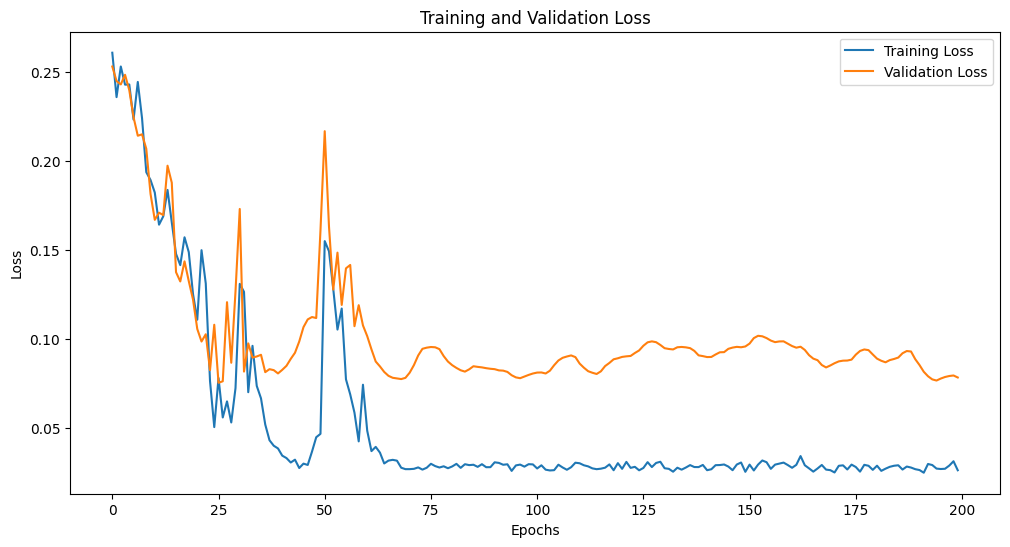

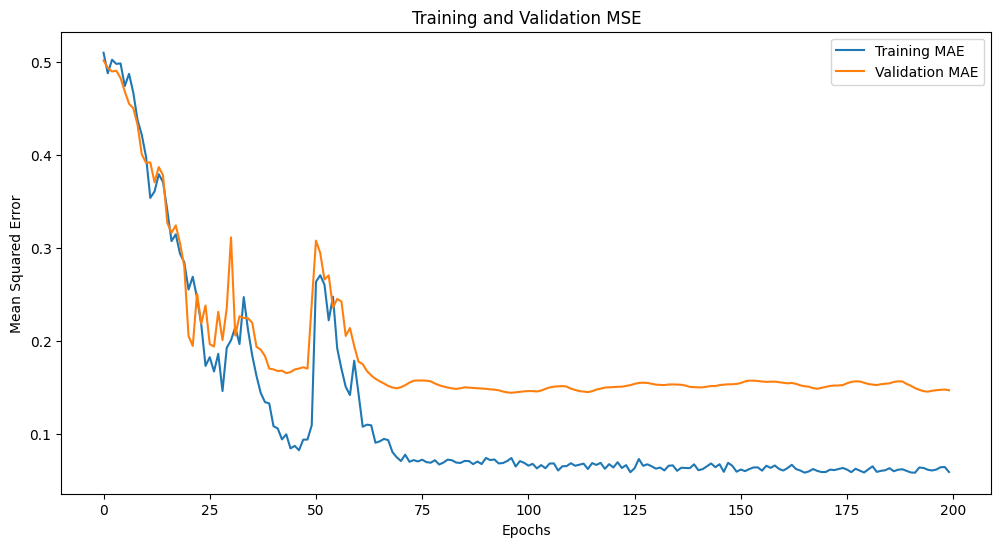

In [6]:
import matplotlib.pyplot as plt

# Plot training and validation loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training and validation MSE
plt.figure(figsize=(12, 6))
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Training and Validation MSE')
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.show()


In [7]:
import pandas as pd
from tensorflow.keras.models import load_model
from sklearn.metrics import accuracy_score, confusion_matrix

# Define threshold
threshold = 0.5  # Predictions above this are classified as `correct` (0), below as `incorrect` (1)

# Load the trained model
model = load_model("stage2-final.keras")

# Predict on validation set
y_pred = model.predict(X_val).flatten()  # Flatten the predictions for simplicity

# Apply threshold
# y_classified = [0 if pred > threshold else 1 for pred in y_pred]  # 0 = correct, 1 = incorrect

y_classified = []
for pred in y_pred:
    if pred > threshold:
        y_classified.append(1)  # Correct
    else:
        y_classified.append(0)  # Incorrect
print(y_classified)

# Convert to a DataFrame for easy analysis
results_df = pd.DataFrame({
    'True Label': y_val,
    'Predicted Value': y_pred,
    'Predicted Class': y_classified
})

# Save results to a CSV file for analysis
results_df.to_csv("validation_results.csv", index=False)
print("Validation results saved to 'validation_results.csv'.")

# Display the first few rows
print(results_df.head())

# Calculate and display accuracy
accuracy = accuracy_score(y_val, y_classified)
print(f"Accuracy: {accuracy:.2f}")

# Confusion matrix
conf_matrix = confusion_matrix(y_val, y_classified)
print("Confusion Matrix:")
print(conf_matrix)


1/1 [==============================] - 1s 1s/step
[1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1]
Validation results saved to 'validation_results.csv'.
   True Label  Predicted Value  Predicted Class
0           0         0.601037                1
1           0         0.003473                0
2           0         0.002313                0
3           1         0.884715                1
4           1         0.995649                1
Accuracy: 0.81
Confusion Matrix:
[[7 3]
 [0 6]]


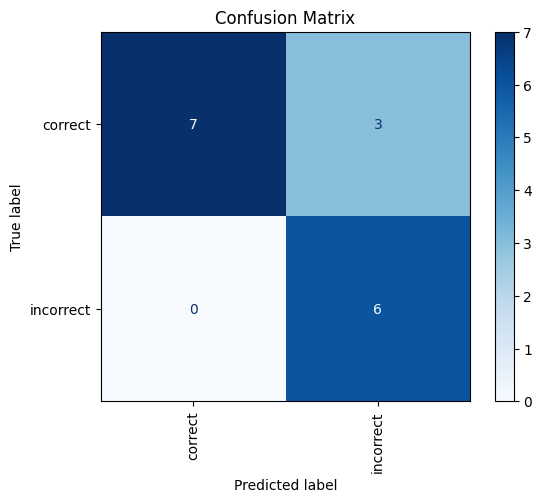

Accuracy: 0.81


In [8]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
import matplotlib.pyplot as plt

# Define a single threshold for classification
threshold = 0.5  # Adjust this value to experiment with different thresholds

# Classify predictions based on the threshold
# y_classified = [0 if pred > threshold else 1 for pred in y_pred]  # `0` = correct, `1` = incorrect

# Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, labels):
    # Ensure label order matches the data
    cm = confusion_matrix(y_true, y_pred, labels=[0, 1])  # Numerical order: 0 = correct, 1 = incorrect
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap='Blues', xticks_rotation='vertical')
    plt.title('Confusion Matrix')
    plt.grid(False)
    plt.show()

# Ensure the order of labels matches the confusion matrix
true_labels = ["correct", "incorrect"]  # Match this to 0 = correct, 1 = incorrect

# Plot confusion matrix
plot_confusion_matrix(y_val, y_classified, labels=true_labels)

# Calculate and print accuracy
accuracy = accuracy_score(y_val, y_classified)
print(f"Accuracy: {accuracy:.2f}")
